# 성능 최적화 종합실습 : Car seat sales
유아용 카시트 매출액을 예측해 봅시다.

* 카시트에 대해서 지역 매장 별 매출액을 예측하고자 합니다.

![](https://cdn.images.express.co.uk/img/dynamic/24/590x/child-car-seat-986556.jpg?r=1532946857754)

## 1.환경준비

### (1) Import

In [1]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 모델링
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import * 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

import warnings
warnings.filterwarnings(action='ignore')

C:\Users\allsa\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### (2) 함수 생성

* 선형회귀용 전진선택법

In [2]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

def forward_stepwise_linear(x_train, y_train):

    # 변수목록, 선택된 변수 목록, 단계별 모델과 AIC 저장소 정의
    features = list(x_train)
    selected = []
    step_df = pd.DataFrame({ 'step':[], 'feature':[],'aic':[]})

    # 
    for s in range(0, len(features)) :
        result =  { 'step':[], 'feature':[],'aic':[]}

        # 변수 목록에서 변수 한개씩 뽑아서 모델에 추가
        for f in features :
            vars = selected + [f]
            x_tr = x_train[vars]
            model = OLS(y_train, add_constant(x_tr)).fit()
            result['step'].append(s+1)
            result['feature'].append(vars)
            result['aic'].append(model.aic)
        
        # 모델별 aic 집계
        temp = pd.DataFrame(result).sort_values('aic').reset_index(drop = True)

        # 만약 이전 aic보다 새로운 aic 가 크다면 멈추기
        if step_df['aic'].min() < temp['aic'].min() :
            break
        step_df = pd.concat([step_df, temp], axis = 0).reset_index(drop = True)

        # 선택된 변수 제거
        v = temp.loc[0,'feature'][s]
        features.remove(v)

        selected.append(v)
    
    # 선택된 변수와 step_df 결과 반환
    return selected, step_df

* 변수 중요도 그래프

In [3]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

### (3) Data Loading

In [4]:
data_path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/Carseats.csv'
data = pd.read_csv(data_path)

**변수설명**
> * Sales - 각 지역 판매량(단위 : 1000개) <== Target
* CompPrice - 각 지역 경쟁사 가격
* Income - 각 지역 평균 소득수준(단위 : 1000달러)
* Advertising - 각 지역, 회사의 광고 예산(단위 : 1000달러)
* Population - 지역 인구수(단위 : 1000명)
* Price - 자사 지역별 판매가격
* ShelveLoc - 진열상태
* Age - 지역 인구의 평균 연령
* Education - 각 지역 교육수준 레벨
* Urban - 매장 도시 지역 여부
* US - 매장이 미국에 있는지 여부

In [5]:
data.info

<bound method DataFrame.info of      Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0     9.50        138      73           11         276    120       Bad   42   
1    11.22        111      48           16         260     83      Good   65   
2    10.06        113      35           10         269     80    Medium   59   
3     7.40        117     100            4         466     97    Medium   55   
4     4.15        141      64            3         340    128       Bad   38   
..     ...        ...     ...          ...         ...    ...       ...  ...   
395  12.57        138     108           17         203    128      Good   33   
396   6.14        139      23            3          37    120    Medium   55   
397   7.41        162      26           12         368    159    Medium   40   
398   5.94        100      79            7         284     95       Bad   50   
399   9.71        134      37            0          27    120      Good   49   

     Ed

## 2.데이터 이해

* 둘러보기

In [6]:
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


## 3.데이터 준비

### (1) 데이터 정리

In [7]:
data['Diff_Price'] = data['CompPrice'] - data['Price']
data.drop('CompPrice', axis = 1, inplace = True)

### (2) 데이터분할1 : x, y 나누기

In [8]:
X = data.drop('Sales', axis=1)
y = data.loc[:, 'Sales']

### (3) NA 조치

### (4) 가변수화

In [9]:
X = pd.get_dummies(data=X, columns=['ShelveLoc', 'Urban', 'US'], drop_first=True)

In [10]:
X.head()

,Income,Advertising,Population,Price,Age,Education,Diff_Price,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,73,11,276,120,42,17,18,0,0,1,1
1,48,16,260,83,65,10,28,1,0,1,1
2,35,10,269,80,59,12,33,0,1,1,1
3,100,4,466,97,55,14,20,0,1,1,1
4,64,3,340,128,38,13,13,0,0,1,0


### (5) 데이터분할2 : train : validation 나누기

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3)

### (6) Scaling
KNN 알고리즘을 적용하기 위해서는 스케일링을 해야 합니다.

In [12]:
scaler = MinMaxScaler()

X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)

## 4.모델링



### (1) 선형회귀

In [26]:
model_rs = LinearRegression()

In [27]:
selected, df =forward_stepwise_linear(X_train, y_train)

In [28]:
model_rs.fit(X_train[selected], y_train)

LinearRegression()

In [30]:
pred = model_rs.predict(X_val[selected])

In [31]:
r2_score(y_val, pred)

0.8673121084464983

In [32]:
mean_squared_error(y_val, pred, squared=False)

0.9551796341537228

In [33]:
mean_absolute_error(y_val, pred)

0.7238809575523933

In [34]:
1 - mean_absolute_percentage_error(y_val, pred)

0.8979403290757313

In [35]:
df.loc[df['aic'] == df['aic'].min()]

,step,feature,aic
56,8.0,"[Diff_Price, ShelveLoc_Good, Advertising, Shel...",833.013446


In [36]:
selected

['Diff_Price',
 'ShelveLoc_Good',
 'Advertising',
 'ShelveLoc_Medium',
 'Age',
 'Income',
 'Urban_Yes',
 'US_Yes']

### (2) KNN

In [37]:
model = KNeighborsRegressor()

In [41]:
model_rs = GridSearchCV(estimator=model, param_grid={'n_neighbors': [3, 5, 10], 'metric': ['chevyshev', 'minkowski', 'cityblock', 'euclidean']}, cv=5)
model_rs.fit(X_train_s, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['chevyshev', 'minkowski', 'cityblock',
                                    'euclidean'],
                         'n_neighbors': [3, 5, 10]})

In [42]:
pred = model_rs.predict(X_val)

In [43]:
r2_score(y_val, pred)

0.39941922962942367

In [44]:
mean_squared_error(y_val, pred, squared=False)

2.032146992714848

In [45]:
mean_absolute_error(y_val, pred)

1.6360999999999999

In [46]:
1 - mean_absolute_percentage_error(y_val, pred)

0.7636439129452615

In [47]:
result = pd.DataFrame(model_rs.cv_results_)#.loc[:, ['param_n_neighbors', 'mean_test_scores']]
result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.0004,0.00049,0.0,0.0,chevyshev,3,"{'metric': 'chevyshev', 'n_neighbors': 3}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
1,0.0002,0.00040,0.0,0.0,chevyshev,5,"{'metric': 'chevyshev', 'n_neighbors': 5}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
2,0.0002,0.00040,0.0,0.0,chevyshev,10,"{'metric': 'chevyshev', 'n_neighbors': 10}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
3,0.0002,0.00040,0.0,0.0,minkowski,3,"{'metric': 'minkowski', 'n_neighbors': 3}",0.456457,0.480018,0.360682,0.434109,0.432053,0.432664,0.039981,8
4,0.0006,0.00049,0.0,0.0,minkowski,5,"{'metric': 'minkowski', 'n_neighbors': 5}",0.455367,0.483520,0.360902,0.500436,0.468684,0.453782,0.048810,4


In [48]:
temp = result.loc[:, ['mean_test_score', 'param_n_neighbors']]

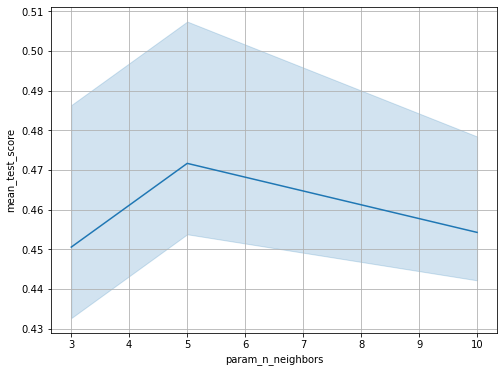

In [49]:
plt.figure(figsize=(8,6))
sns.lineplot(x = 'param_n_neighbors', y = 'mean_test_score',  data = temp)
plt.grid()
plt.show()

### (3) Decision Tree

In [ ]:
model = DecisionTreeRegressor()

In [ ]:
model_rs = GridSearchCV(estimator=model, param_grid={'max_depth': [2, 3, 5, 10, 30], 'min_samples_leaf': range(10, 50, 10)}, cv=5)
model_rs.fit(X_train, y_train)

In [ ]:
pred = model_rs.predict(X_val)

In [ ]:
r2_score(y_val, pred)

In [ ]:
mean_squared_error(y_val, pred, squared=False)

In [ ]:
mean_absolute_error(y_val, pred)

In [ ]:
1 - mean_absolute_percentage_error(y_val, pred)

In [ ]:
result = pd.DataFrame(model_rs.cv_results_)#.loc[:, ['param_max_depth', 'mean_test_scores']]
result.head()

In [ ]:
temp = result.loc[:, ['mean_test_score', 'param_min_samples_leaf', 'param_max_depth']]

In [ ]:
plt.figure(figsize=(8,6))
sns.lineplot(x = '', y = 'param_min_samples_leaf',  data = temp, hue='param_max_depth')
plt.grid()
plt.show()

### (4) Random Forest

In [69]:
model_rs = RandomForestRegressor()

In [70]:
# model_rs = RandomizedSearchCV(estimator=model, param_distributions={'max_depth': range(3, 10), 'min_samples_leaf': range(10, 200)}, cv=5)
model_rs.fit(X_train, y_train)

RandomForestRegressor()

In [71]:
pred = model_rs.predict(X_val)

In [72]:
r2_score(y_val, pred)

0.8169641680096583

In [73]:
mean_squared_error(y_val, pred, squared=False)

1.1218569076164158

In [74]:
mean_absolute_error(y_val, pred)

0.8985283333333335

In [75]:
1 - mean_absolute_percentage_error(y_val, pred)

0.8755804263104983

In [78]:
result = pd.DataFrame(model_rs.)#.loc[:, ['param_max_depth', 'mean_test_scores']]
result.head()

ValueError: DataFrame constructor not properly called!

In [58]:
temp = result.loc[:, ['mean_test_score', 'param_min_samples_leaf', 'param_max_depth']]

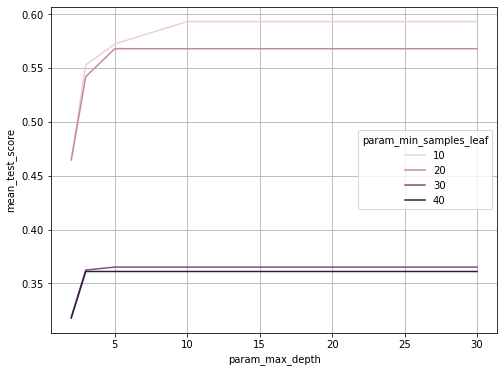

In [59]:
plt.figure(figsize=(8,6))
sns.lineplot(x = 'param_max_depth', y = 'mean_test_score',  data = temp, hue='param_min_samples_leaf')
plt.grid()
plt.show()

### (5) XGB

In [79]:
model = XGBRegressor()

In [80]:
model_rs = GridSearchCV(estimator=model, param_grid={'learning_rate':np.linspace(0.001,0.3,100), 'n_estimators':[20,30,50, 100]}, cv=5)
model_rs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
       0.21241414, 0.21543434, 0.21845455, 0.22147475, 0.22449495,
       0.22751515, 0.23053535, 0.23355556, 0.23657576, 0.23959596,
       0.24261616, 0.24563636, 0.24865657, 0.25167677, 0.25469697,
       0.25771717, 0.26073737, 0.26375758, 0.26677778, 

In [81]:
pred = model_rs.predict(X_val)

In [82]:
r2_score(y_val, pred)

0.7521353002910647

In [83]:
mean_squared_error(y_val, pred, squared=False)

1.3054996133651962

In [84]:
mean_absolute_error(y_val, pred)

1.0051305824915568

In [85]:
1 - mean_absolute_percentage_error(y_val, pred)

0.8601543836039762

### (6) SVM

In [86]:
from sklearn.svm import SVR

In [87]:
model = SVR()

In [88]:
model_gs = GridSearchCV(estimator=model, param_grid={'C': np.linspace(0.001, 100, 1000), 'gamma': np.linspace(0.001, 100, 1000)})

In [ ]:
model_gs.fit(X_train, y_train)

In [ ]:
pred = model_rs.predict(X_val)

In [ ]:
r2_score(y_val, pred)

In [ ]:
mean_squared_error(y_val, pred, squared=False)

In [ ]:
mean_absolute_error(y_val, pred)

In [ ]:
1 - mean_absolute_percentage_error(y_val, pred)